# **Experiment Notebook**



### Context


In this notebook, the student conducted customer segmentation using categorical unsupervised learning algorithms. Specifically, he used k-mode to create 3 model variations. Instead of the shared folder mentioned in the main report, this code was executed locally. There may be some problems with viewing EDA graphs due to conversion issues when moving files between the local system and Colab; it is the same as the rest of the group and included in the report.

### 0. Import Packages, Set Global Variables, Define Helpers


In [ ]:
# import packages
import os
import pandas as pd
from geopy.distance import geodesic
from dataprep.eda import plot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import numpy as np
from kmodes.kmodes import KModes

In [ ]:
# set global variables

random_state = 42

In [ ]:
# calculate geodesic distance from customer address to transaction location, in km

def trans_dist_to_cust_addr(cust_lat=None, cust_long=None, merch_lat=None, merch_long=None):
  cust_coords = list(zip(cust_lat, cust_long))
  merch_coords = list(zip(merch_lat, merch_long))

  dist = [geodesic(cust, merch).kilometers for cust, merch in zip(cust_coords, merch_coords)]
  return dist


In [ ]:
# generate clusters based on start, stop, and n steps

def gen_cluster_dict(start, stop, step):
  cluster_list = list(range(start, stop+1, step))
  cluster_dict = {cluster: cluster for cluster in cluster_list}
  return cluster_dict

In [ ]:
"""
The following code was created to incorporate important features to customer segmentation, which has been left for further exploration as mentioned in the main report:

from datetime import datetime
import pytz
from timezonefinder import TimezoneFinder

def get_local_month_and_time(row):
    # Get timezone from coordinates
    tf = TimezoneFinder()
    timezone_str = tf.timezone_at(lat=row['merch_lat'], lng=row['merch_long'])
    timezone = pytz.timezone(timezone_str)

    # Convert Unix time to local time
    local_time = datetime.strptime(row['transaction_date'], '%Y-%m-%d %H:%M:%S').astimezone(timezone)
    local_time = local_time.strftime("%H")

    return local_time

"""

'\nfrom datetime import datetime\nimport pytz\nfrom timezonefinder import TimezoneFinder\n\ndef get_local_month_and_time(row):\n    # Get timezone from coordinates\n    tf = TimezoneFinder()\n    timezone_str = tf.timezone_at(lat=row[\'merch_lat\'], lng=row[\'merch_long\'])\n    timezone = pytz.timezone(timezone_str)\n\n    # Convert Unix time to local time\n    local_time = datetime.strptime(row[\'transaction_date\'], \'%Y-%m-%d %H:%M:%S\').astimezone(timezone)\n    local_time = local_time.strftime("%H")\n\n    return local_time\n\n'

### 1.   Load Dataset


In [ ]:
"""
In Google Drive, go to "Shared with me", right click Group_34_AT3_240524 file/folder, select "Organize", then "Add shortcut". Add to "My Drive".
You may need to restart your colab runtime.

"""
# define folder path

folder_path = "C:/Users/zerob/Desktop/MLAA_ASG_3/data/"



In [ ]:
# extracing list of transaction dataframes in folder, then read into full df

transaction_df_names = [df for df in os.listdir(folder_path) if "transactions" in df]
num_transaction_dfs = len(transaction_df_names)
transaction_df = pd.DataFrame()

for df_name in transaction_df_names:
  df = pd.read_csv(f"{folder_path}{df_name}", engine='python', sep="\|")
  transaction_df = pd.concat([transaction_df, df], ignore_index=True)

In [ ]:
# load customer data

customer_df_name = "customers.csv"
customer_df = pd.read_csv(f"{folder_path}{customer_df_name}", engine='python', sep="\|")

In [ ]:
# Merge into single dataframe through 'cc_num' column
df_merged = pd.merge(transaction_df, customer_df, on='cc_num', how='left')

# Delete and rename duplicate column
df_merged = df_merged.drop(columns=['acct_num_y'])
df_merged = df_merged.rename(columns={'acct_num_x': 'acct_num'})

# Cast dates to datetime in order to add new 'age_at_transaction' variable
df_merged['transaction_date'] = pd.to_datetime(df_merged['unix_time'], unit='s')
df_merged['dob'] = pd.to_datetime(df_merged['dob'])
df_merged['age_at_transaction'] = (df_merged['transaction_date'] - df_merged['dob']).dt.days // 365

# Cast 'is_fraud' column as an integer to plot correlation
df_merged['is_fraud'] = df_merged['is_fraud'].astype(int)

# Show new merged df
df_merged

cc_num      acct_num                         trans_num  \
0        4218196001337  888022315787  91ab12e73ef38206e1121e9648d2408d   
1        4218196001337  888022315787  071553d533a6822a4431c354c434ddcb   
2        4218196001337  888022315787  0cfad38ef15e4749eff68dc83f62c151   
3        4218196001337  888022315787  5782693d7c70f062f258cb30bfa8900f   
4        4218196001337  888022315787  35fd7db657d7e30dd608c37f7798186e   
...                ...           ...                               ...   
4260899  4246163034387   21414345345  7432f399b000172fcc1e8790f6fc965b   
4260900  4246163034387   21414345345  7b6dda3778381981a53b9aa5043fff15   
4260901  4246163034387   21414345345  a42a8a1fa3919010412c0302912acf67   
4260902  4246163034387   21414345345  45f5c90dd51fe578857b2c6fa8e55c64   
4260903  4246163034387   21414345345  6ba78d99dcb30dbb5f3611eee87af76a   

          unix_time       category    amt  is_fraud  \
0        1558719550  gas_transport  69.12         0   
1        1569425519    grocery_pos  68.11         0   
2        1577205601       misc_net  40.35         0   
3        1571428238    grocery_pos  96.22         0   
4        1549840400  gas_transport  71.89         0   
...             ...            ...    ...       ...   
4260899  1590472417       misc_pos   1.71         0   
4260900  1624189162  entertainment   1.85         0   
4260901  1607057141   shopping_pos   5.22         0   
4260902  1621153529  entertainment   7.79         0   
4260903  1668858175  personal_care   1.45         0   

                                   merchant  merch_lat  merch_long  ...  \
0                            Phillips Group  39.491416  -75.588522  ...   
1                                Tucker Ltd  40.890319  -75.573359  ...   
2                                 Dixon PLC  39.244958  -74.475327  ...   
3                            Lambert-Cooper  39.656925  -75.802342  ...   
4                              Griffith LLC  40.313342  -74.220434  ...   
...                                     ...        ...         ...  ...   
4260899                      Moore and Sons  39.947898  -73.705782  ...   
4260900              Orr, Miller and Lester  40.986267  -73.403986  ...   
4260901                      Petersen-Davis  40.973092  -74.058395  ...   
4260902  Castillo, Valenzuela and Rodriguez  41.133557  -73.279871  ...   
4260903             Zhang, Webb and Richard  40.930376  -73.042878  ...   

              city state    zip      lat     long city_pop  \
0           Ambler    PA  19002  40.1809 -75.2156    32412   
1           Ambler    PA  19002  40.1809 -75.2156    32412   
2           Ambler    PA  19002  40.1809 -75.2156    32412   
3           Ambler    PA  19002  40.1809 -75.2156    32412   
4           Ambler    PA  19002  40.1809 -75.2156    32412   
...            ...   ...    ...      ...      ...      ...   
4260899  Levittown    NY  11756  40.7254 -73.5166    42791   
4260900  Levittown    NY  11756  40.7254 -73.5166    42791   
4260901  Levittown    NY  11756  40.7254 -73.5166    42791   
4260902  Levittown    NY  11756  40.7254 -73.5166    42791   
4260903  Levittown    NY  11756  40.7254 -73.5166    42791   

                           job        dob    transaction_date  \
0        Accounting technician 1959-10-03 2019-05-24 17:39:10   
1        Accounting technician 1959-10-03 2019-09-25 15:31:59   
2        Accounting technician 1959-10-03 2019-12-24 16:40:01   
3        Accounting technician 1959-10-03 2019-10-18 19:50:38   
4        Accounting technician 1959-10-03 2019-02-10 23:13:20   
...                        ...        ...                 ...   
4260899        Equities trader 2003-11-15 2020-05-26 05:53:37   
4260900        Equities trader 2003-11-15 2021-06-20 11:39:22   
4260901        Equities trader 2003-11-15 2020-12-04 04:45:41   
4260902        Equities trader 2003-11-15 2021-05-16 08:25:29   
4260903        Equities trader 2003-11-15 2022-11-19 11:42:55   

         age_at_transaction  
0        

In [ ]:
# generate indices for splitting data

# generate indices of split
train_index, unseen_index = train_test_split(range(len(df_merged)), test_size=0.2, random_state=random_state)
validation_index, test_index = train_test_split(range(len(unseen_index)), test_size=0.5, random_state=random_state)

print("Training Set Size:", len(train_index), "rows")
print("Validation Set Size:", len(validation_index), "rows")
print("Test Set Size:", len(test_index), "rows")



Training Set Size: 3408723 rows
Validation Set Size: 426090 rows
Test Set Size: 426091 rows


### 2. Explore Dataset

In [ ]:
# viewing info of original transaction data

transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4260904 entries, 0 to 4260903
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   cc_num      object 
 1   acct_num    object 
 2   trans_num   object 
 3   unix_time   object 
 4   category    object 
 5   amt         float64
 6   is_fraud    object 
 7   merchant    object 
 8   merch_lat   float64
 9   merch_long  float64
dtypes: float64(3), object(7)
memory usage: 325.1+ MB


In [ ]:
# viewing info of orignal customer data

customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ssn       1000 non-null   object 
 1   cc_num    1000 non-null   int64  
 2   first     1000 non-null   object 
 3   last      1000 non-null   object 
 4   gender    1000 non-null   object 
 5   street    1000 non-null   object 
 6   city      1000 non-null   object 
 7   state     1000 non-null   object 
 8   zip       1000 non-null   int64  
 9   lat       1000 non-null   float64
 10  long      1000 non-null   float64
 11  city_pop  1000 non-null   int64  
 12  job       1000 non-null   object 
 13  dob       1000 non-null   object 
 14  acct_num  1000 non-null   int64  
dtypes: float64(2), int64(4), object(9)
memory usage: 117.3+ KB


In [ ]:
# viewing NaN values of both original datasets to check data quality

dupes_transaction = transaction_df.isna().sum()
dupes_customer = customer_df.isna().sum()

print(f"Transaction dataset NA values:\n{dupes_transaction}")


print("\n")
print(f"Customer datasetNA values:\n{dupes_customer}")



Transaction dataset NA values:
cc_num        0
acct_num      0
trans_num     0
unix_time     0
category      0
amt           0
is_fraud      0
merchant      0
merch_lat     0
merch_long    0
dtype: int64


Customer datasetNA values:
ssn         0
cc_num      0
first       0
last        0
gender      0
street      0
city        0
state       0
zip         0
lat         0
long        0
city_pop    0
job         0
dob         0
acct_num    0
dtype: int64


In [ ]:
# checking duplicates of original datasets to check data quality

dupes_transaction = transaction_df.duplicated().sum()
print(f'There are {dupes_transaction} duplidates within the transaction dataset.\n')

dupes_customer = customer_df.duplicated().sum()
print(f'There are {dupes_customer} duplidates within the transaction dataset.\n')

There are 0 duplidates within the transaction dataset.

There are 0 duplidates within the transaction dataset.



In [ ]:
# From here on, we explore only the training data to avoid data leakage

# Explore variable info of train df
df_train = df_merged.iloc[train_index]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3408723 entries, 2822479 to 1692743
Data columns (total 25 columns):
 #   Column              Dtype         
---  ------              -----         
 0   cc_num              object        
 1   acct_num            object        
 2   trans_num           object        
 3   unix_time           object        
 4   category            object        
 5   amt                 float64       
 6   is_fraud            int32         
 7   merchant            object        
 8   merch_lat           float64       
 9   merch_long          float64       
 10  ssn                 object        
 11  first               object        
 12  last                object        
 13  gender              object        
 14  street              object        
 15  city                object        
 16  state               object        
 17  zip                 int64         
 18  lat                 float64       
 19  long                float64       
 

In [ ]:
# Explore summary statistics of train df
df_train.describe()

amt      is_fraud     merch_lat    merch_long           zip  \
count  3.408723e+06  3.408723e+06  3.408723e+06  3.408723e+06  3.408723e+06   
mean   6.901268e+01  1.180207e-03  3.735218e+01 -9.247369e+01  5.189906e+04   
std    1.641259e+02  3.433387e-02  5.503152e+00  1.741468e+01  2.996963e+04   
min    1.000000e+00  0.000000e+00  1.859001e+01 -1.603677e+02  1.571000e+03   
25%    9.100000e+00  0.000000e+00  3.370085e+01 -9.902786e+01  2.737100e+04   
50%    4.448000e+01  0.000000e+00  3.819190e+01 -8.727531e+01  4.920200e+04   
75%    8.158000e+01  0.000000e+00  4.120542e+01 -7.965771e+01  7.870400e+04   
max    4.130053e+04  1.000000e+00  6.577610e+01 -6.724632e+01  9.970500e+04   

                lat          long      city_pop  age_at_transaction  
count  3.408723e+06  3.408723e+06  3.408723e+06        3.408723e+06  
mean   3.735206e+01 -9.247356e+01  3.035928e+05        4.288119e+01  
std    5.473020e+00  1.740469e+01  5.694337e+05        1.768364e+01  
min    1.958930e+01 -1.593683e+02  1.050000e+02        1.100000e+01  
25%    3.378360e+01 -9.868950e+01  2.010300e+04        2.900000e+01  
50%    3.824200e+01 -8.717940e+01  6.759300e+04        4.100000e+01  
75%    4.094570e+01 -7.994400e+01  2.420370e+05        5.400000e+01  
max    6.478050e+01 -6.824480e+01  2.906700e+06        9.500000e+01

In [ ]:
# Plot distribution of train df
plot(df_train)

Output hidden; open in https://colab.research.google.com to view.

### 3. Explore Target variable

In [ ]:
# As we perform unsupervised learning, there is no target variable.

### 4. Explore Variables of Interest

In [ ]:
# Set variables of interest
cat_vars= df_train[['category','is_fraud','merchant','gender','state']]
num_vars= df_train[['amt','merch_lat','merch_long','zip','lat','long','city_pop','transaction_date','dob','age_at_transaction','is_fraud']]
ord_vars= df_train[['transaction_date','dob','age_at_transaction']]

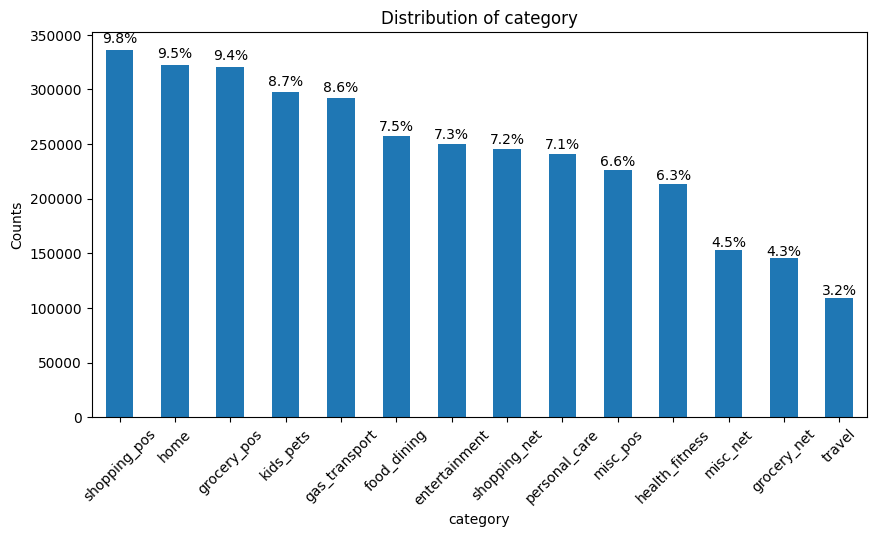

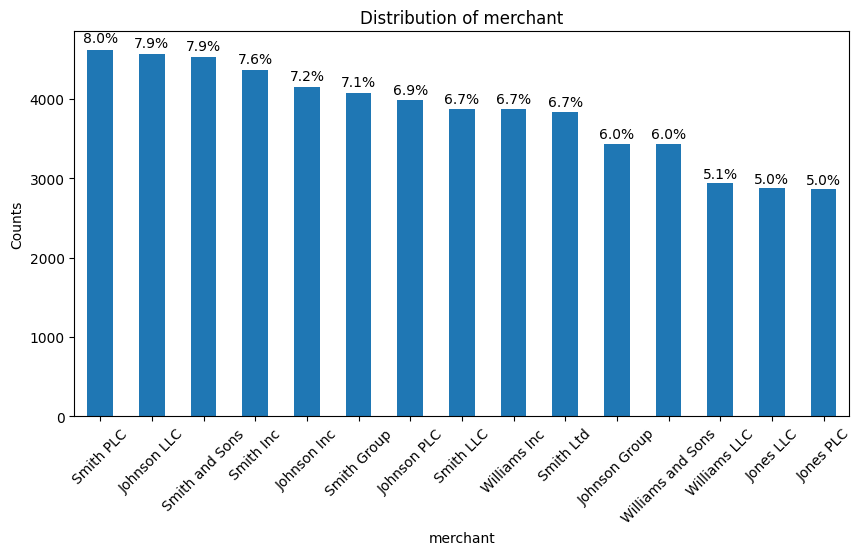

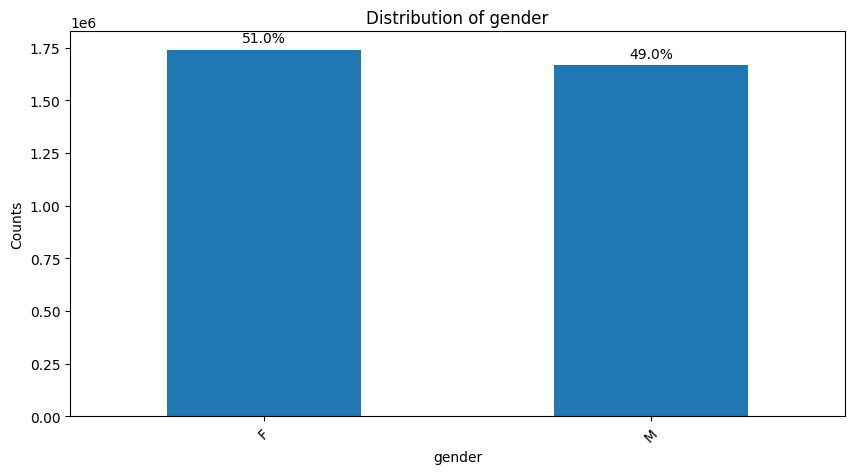

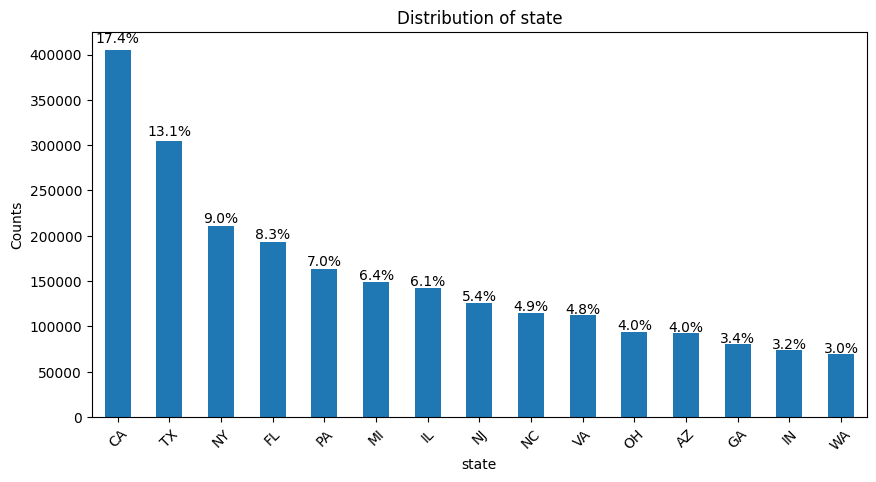

In [ ]:
# Plot distribution of categorical variables
for cat_var in cat_vars:
    counts = df_train[cat_var].value_counts().head(15)
    total = counts.sum()

    plt.figure(figsize=(10, 5))
    ax = counts.plot(kind='bar')
    plt.title(f'Distribution of {cat_var}')
    plt.xlabel(cat_var)
    plt.ylabel('Counts')
    plt.xticks(rotation=45)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{(height/total)*100:.1f}%', (x + width/2, y + height*1.02), ha='center')

    plt.show()


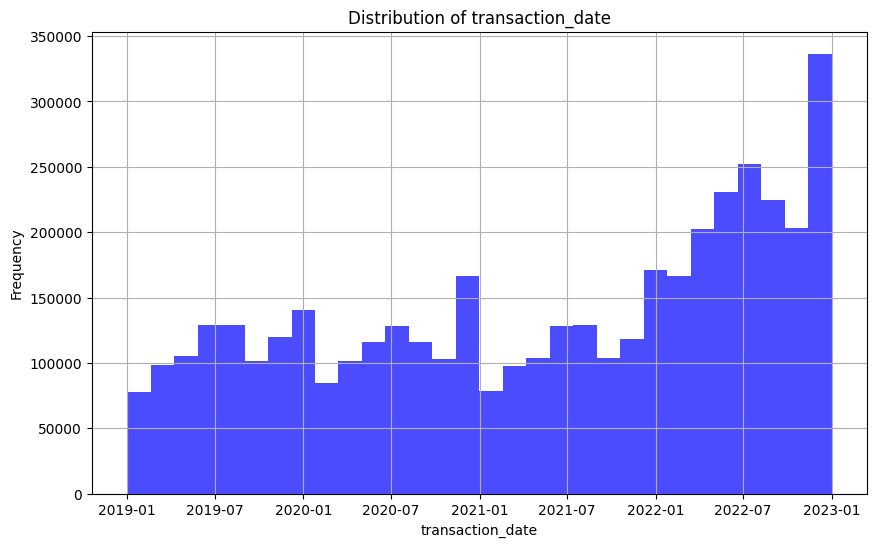

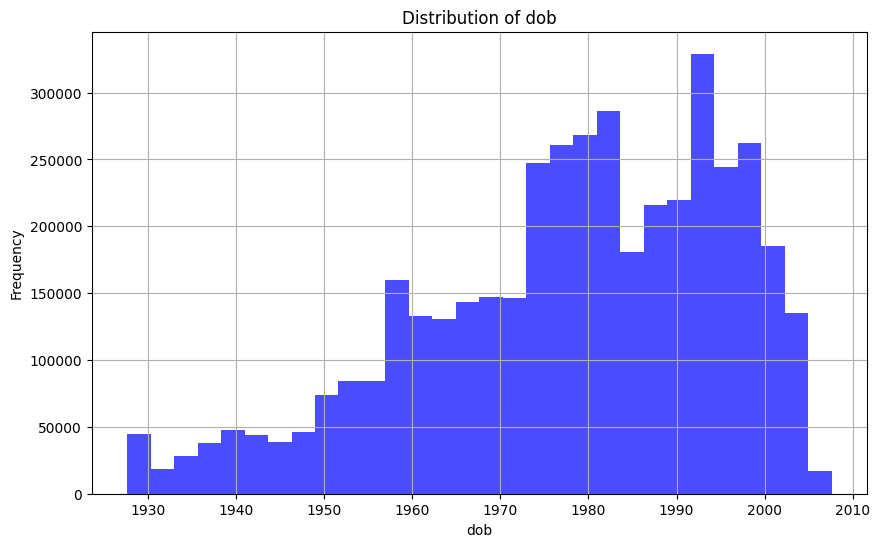

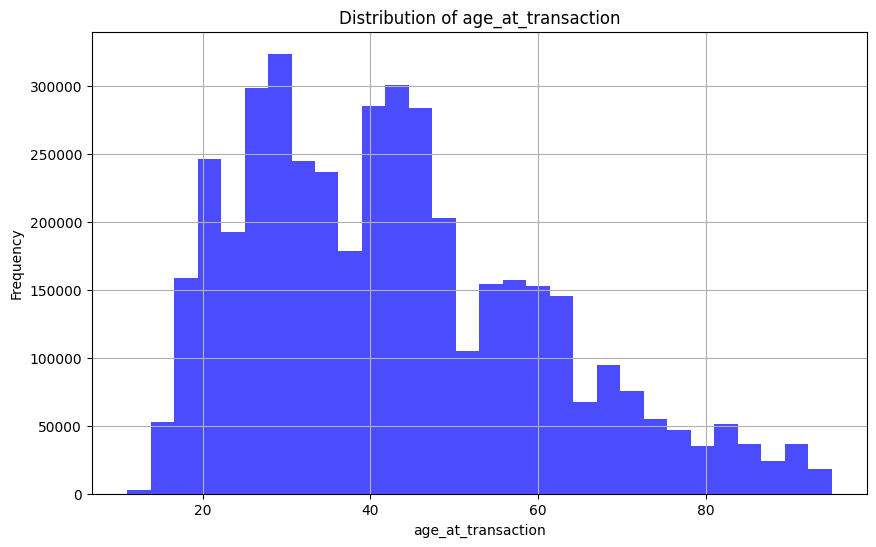

In [ ]:
# Plot distribution of ordinal variables
for ord_var in ord_vars:
    plt.figure(figsize=(10, 6))
    plt.hist(df_merged[ord_var].dropna(), bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution of {ord_var}')
    plt.xlabel(ord_var)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

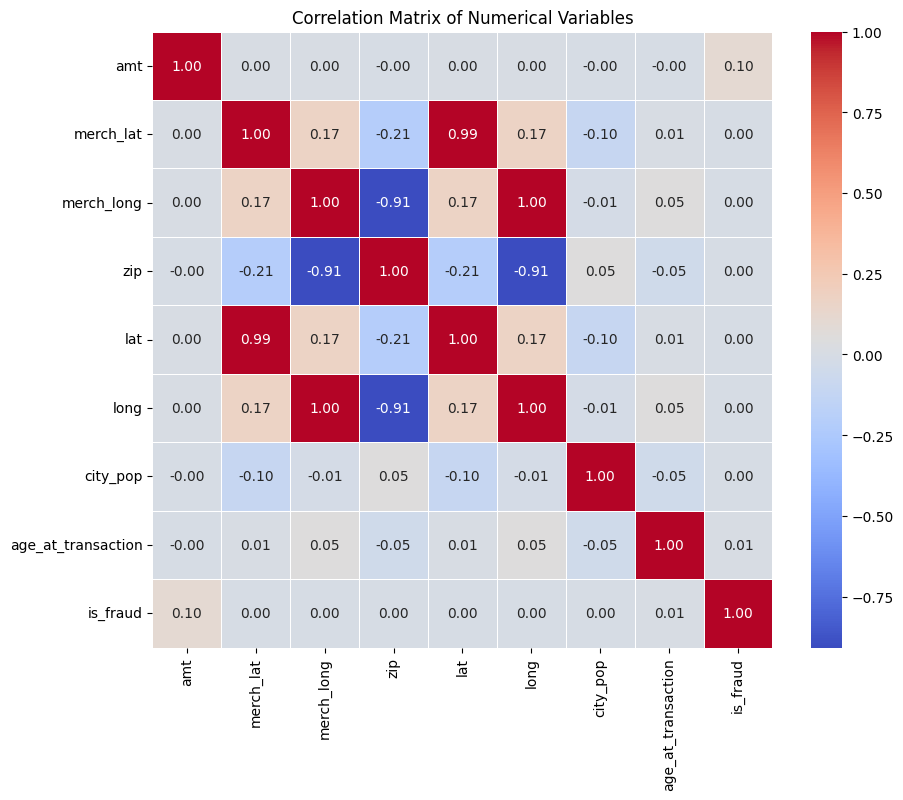

In [ ]:
# Plot correlation between numerical variables
corr_matrix = num_vars.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()


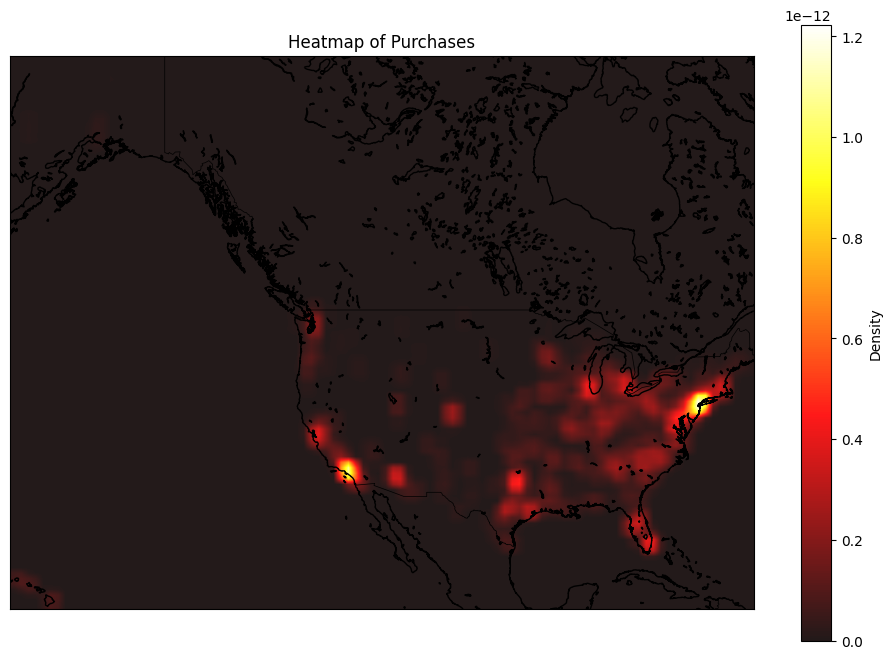

In [ ]:
# Plot heatmap of purchases
fig, ax = plt.subplots(figsize=(12, 8))
m = Basemap(projection='merc', llcrnrlat=df_merged['merch_lat'].min() , urcrnrlat=df_merged['merch_lat'].max() ,
            llcrnrlon=df_merged['merch_long'].min() , urcrnrlon=df_merged['merch_long'].max() , resolution='i', ax=ax)

m.drawcoastlines()
m.drawcountries()

x, y = m(df_merged['merch_long'].values, df_merged['merch_lat'].values)
heatmap, xedges, yedges = np.histogram2d(x, y, bins=100, density=True)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', alpha=0.9, interpolation='bilinear')
plt.colorbar(label='Density')
plt.title('Heatmap of Purchases')
plt.show()


### 5. Prepare Data

In [ ]:
df_cleaned = df_merged.copy()

In [ ]:
# removing fraudulent transactions as they do not accurately reflect customer behavior
df_cleaned = df_cleaned[df_cleaned['is_fraud']==0]

In [ ]:
# calculating distance
df_cleaned['trans_dist_to_home'] = trans_dist_to_cust_addr(cust_lat=df_cleaned['lat'], cust_long=df_cleaned['long'], merch_lat=df_cleaned['merch_lat'], merch_long=df_cleaned['merch_long'])

In [ ]:
"""
The following code was created to incorporate important features to customer segmentation, which has been left for further exploration as mentioned in the main report:

# create transaction time
df_cleaned['trans_time_local'] = df_cleaned.apply(get_local_month_and_time, axis=1)

# time
time_bins = [0, 5, 8, 10, 12, 14, 16, 18, 20, 24]
time_names = ['Late night', 'Early Morning', 'Mid-Morning', 'Late Morning',
         'Early Afternoon', 'Mid-Afternoon', 'Late Afternoon', 'Evening', 'Night']

df_cleaned['trans_time_range'] = pd.cut(pd.to_numeric(df_cleaned['transaction_time_local']), time_bins, labels=time_names)

"""

# binning variables

# amt (during EDA, we see that not many transactions go above $10,000, with majority under $1,000)
amt_bins = [0, 11, 26, 51, 101, 201, 501, 1001, 5001, 10001, 20001, float('inf')]
amt_names = ['$0 - $10', '$11 - $25', '$26 - $50', '$51 - $100', '$101 - $200',
         '$201 - $500', '$501 - $1000', '$1001 - $5000', '$5001 - $10000',
         '$10001 - $20000', '$20001 and above']

df_cleaned['amt_range'] = pd.cut(df_cleaned['amt'], amt_bins, labels=amt_names)

# age bins
age_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, np.inf]
age_names = ['0-4 years', '5-9 years', '10-14 years', '15-19 years', '20-24 years', '25-29 years',
         '30-34 years', '35-39 years', '40-44 years', '45-49 years', '50-54 years', '55-59 years',
         '60-64 years', '65-69 years', '70-74 years', '75-79 years', '80-84 years', '85-89 years',
         '90-94 years', '95-99 years', '100+ years']
df_cleaned['trans_bge_range'] = pd.cut(df_cleaned['age_bt_transaction'], age_bins, labels=age_names)

# distance
dist_bins = [0, 6, 11, 21, 31, 51, 101, 201, float('inf')]
dist_names = ['0-5', '6-10', '11-20', '21-30', '31-50', '51-100', '101-200', '200+']

df_cleaned['trans_dist_range'] = pd.cut(df_cleaned['trans_dist_to_home'], dist_bins, labels=dist_names)


In [ ]:
# getting transaction month

df_cleaned['trans_month_local'] = pd.to_datetime(df_cleaned['transaction_date']).dt.strftime('%B')

In [ ]:
# save dataset
#df_cleaned.to_csv("C:/Users/zerob/Desktop/MLAA_ASG_3/36106-AT3-g34_df_cleaned_25400603_withbins.csv")

### 6. Split Dataset

In [ ]:
# load dataset
#df_cleaned = pd.read_csv("C:/Users/zerob/Desktop/MLAA_ASG_3/36106-AT3-g34_df_cleaned_25400603_withbins.csv")

In [ ]:
count_unique = {}
for col in feat_list:
    unique_count = df_cleaned[col].nunique()
    count_unique[col] = unique_count

print("Number of unique categories for each column:")
print(count_unique)

Number of unique categories for each column:
{'category': 14, 'merchant': 21977, 'gender': 2, 'city': 720, 'job': 502, 'amt_range': 11, 'trans_dist_range': 7, 'trans_age_range': 17, 'trans_month_local': 12}


In [ ]:
# view features
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4255870 entries, 0 to 4260903
Data columns (total 30 columns):
 #   Column              Dtype         
---  ------              -----         
 0   cc_num              object        
 1   acct_num            object        
 2   trans_num           object        
 3   unix_time           object        
 4   category            object        
 5   amt                 float64       
 6   is_fraud            int32         
 7   merchant            object        
 8   merch_lat           float64       
 9   merch_long          float64       
 10  ssn                 object        
 11  first               object        
 12  last                object        
 13  gender              object        
 14  street              object        
 15  city                object        
 16  state               object        
 17  zip                 int64         
 18  lat                 float64       
 19  long                float64       
 20  ci

In [ ]:
"""
We are interested in the following categorical variables, with category of interest depending on marketing targetting and/or product tie-ups:

 4   category            object
 7   merchant            object
 13  gender              object
 15  city                object
 21  job                 object
 26  amt_range           category
 27  trans_age_range     category
 28  trans_dist_range    category
 29  trans_month_local   object

"""

# filtering by product of interest
category_of_interest_a = ["shopping_pos"] # shopping point of sale
merchant_of_interest_b = ["Johnson LLC"] # shopping online
category_of_interest_c = ["entertainment"] # entertainment

df_cleaned_segment_a = df_cleaned[df_cleaned['category'].isin(category_of_interest_a)]
df_cleaned_segment_b = df_cleaned[df_cleaned['merchant'].isin(merchant_of_interest_b)]
df_cleaned_segment_c = df_cleaned[df_cleaned['category'].isin(category_of_interest_c)]


# gathering features of interest

feat_list = ['category', 'merchant', 'gender', 'city', 'job', 'amt_range', 'trans_dist_range', 'trans_age_range',  'trans_month_local']

X_a = df_cleaned_segment_a[feat_list]
X_b = df_cleaned_segment_b[feat_list]
X_c = df_cleaned_segment_c[feat_list]

### 7. Baseline Model

In [ ]:
# with supervised learning, there is no baseline model

### 8. Train Machine Learning Model

#### Model Variation A: Shopping Point of Sale

In [ ]:
# create dict for clusters
cluster_dict_a = gen_cluster_dict(5, 50, 3)
print(cluster_dict_a)

{5: 5, 8: 8, 11: 11, 14: 14, 17: 17, 20: 20, 23: 23, 26: 26, 29: 29, 32: 32, 35: 35, 38: 38, 41: 41, 44: 44, 47: 47, 50: 50}


In [ ]:
# define and fit models based on cluster

best_cost_a = "init"
best_model_dict_a = {}
model_list_a = []
cost_list_a = []


for cluster, cluster_n in cluster_dict_a.items():
  km = KModes(n_clusters=cluster_n, init='Cao', n_init=1, n_jobs=4, max_iter=15, random_state=random_state, verbose=0) # set random_state to global param
  clusters = km.fit_predict(X_a) # as per documentation
  cost_list_a.append(km.cost_)
  model_list_a.append(cluster)
  if best_cost_a == "init":
    best_cost_a = km.cost_
    best_model_dict_a = {cluster:(km, km.cost_)}

  if km.cost_ < best_cost_a:
    best_cost_a = km.cost_
    best_model_dict_a = {cluster:(km, km.cost_)}

  print(f"Model fit for cluster {cluster} complete.")

Model fit for cluster 5 complete.
Model fit for cluster 8 complete.
Model fit for cluster 11 complete.
Model fit for cluster 14 complete.
Model fit for cluster 17 complete.
Model fit for cluster 20 complete.
Model fit for cluster 23 complete.
Model fit for cluster 26 complete.
Model fit for cluster 29 complete.
Model fit for cluster 32 complete.
Model fit for cluster 35 complete.
Model fit for cluster 38 complete.
Model fit for cluster 41 complete.
Model fit for cluster 44 complete.
Model fit for cluster 47 complete.
Model fit for cluster 50 complete.


In [ ]:
# view best model
best_model_dict_a

{50: (KModes(max_iter=15, n_clusters=50, n_init=1, n_jobs=4, random_state=42),
  1809294.0)}

In [ ]:
# Print the cluster centroids
for cluster, (model, cost) in best_model_dict_a.items():
    print(f"Best k = {cluster} \n")
    print(f"Cost = {cost} \n")
    print(f"Centroids: \n {model.cluster_centroids_}")


Best k = 50 

Cost = 1809294.0 

Centroids: 
 [['shopping_pos' 'Stokes and Sons' 'F' 'Brooklyn' 'Patent examiner'
  '$0 - $10' '51-100' '25-29 years' 'December']
 ['shopping_pos' 'Williams and Sons' 'M' 'Los Angeles'
  'Call centre manager' '$51 - $100' '51-100' '40-44 years' 'July']
 ['shopping_pos' 'Taylor LLC' 'F' 'Farmington' 'Nurse, mental health'
  '$51 - $100' '101-200' '20-24 years' 'November']
 ['shopping_pos' 'Smith Group' 'M' 'Houston' 'Software engineer'
  '$0 - $10' '51-100' '20-24 years' 'November']
 ['shopping_pos' 'Davis LLC' 'F' 'Dallas' 'Psychiatric nurse'
  '$51 - $100' '51-100' '35-39 years' 'October']
 ['shopping_pos' 'Miller and Sons' 'F' 'Chicago' 'Camera operator'
  '$26 - $50' '51-100' '20-24 years' 'July']
 ['shopping_pos' 'Williams and Sons' 'F' 'Rolling Meadows'
  'Patent attorney' '$101 - $200' '51-100' '40-44 years' 'November']
 ['shopping_pos' 'Williams and Sons' 'M' 'Denver' 'Accommodation manager'
  '$26 - $50' '101-200' '35-39 years' 'December']
 ['sho

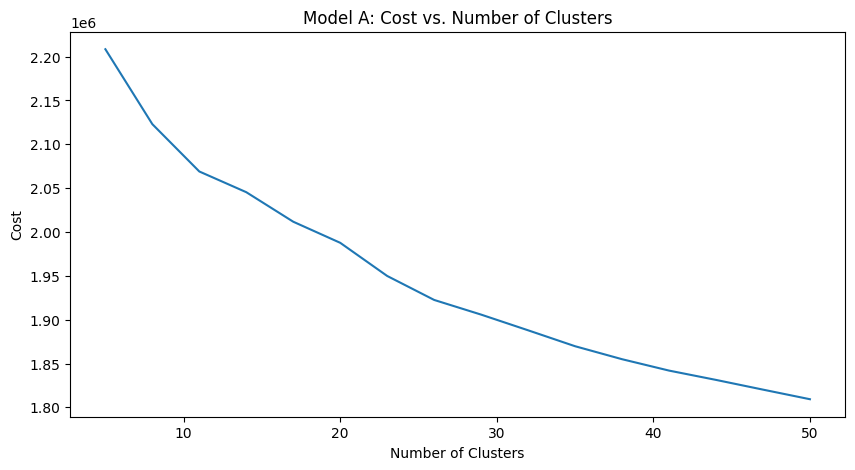

In [ ]:
# plot k clusters vs cost

plt.figure(figsize=(10, 5))
plt.plot(model_list_a, cost_list_a, label='Model cost')
plt.title('Model A: Cost vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()

In [ ]:
# selecting most optimal k by inspecting the elbow plot: k = 10 or 20

k=20

km_final_a = KModes(n_clusters=k, init='Cao', n_init=1, n_jobs=4, max_iter=15, random_state=random_state, verbose=0) # set random_state to global param
clusters_final_a = km_final_a.fit_predict(X_a)
print(f"Optimal centroids, k = {k}: \n {km_final_a.cluster_centroids_}")

Optimal centroids, k = 20: 
 [['shopping_pos' 'Stokes and Sons' 'F' 'Brooklyn' 'Patent examiner'
  '$0 - $10' '51-100' '25-29 years' 'December']
 ['shopping_pos' 'Williams and Sons' 'M' 'Los Angeles'
  'Call centre manager' '$51 - $100' '51-100' '40-44 years' 'July']
 ['shopping_pos' 'Taylor LLC' 'F' 'Farmington' 'Nurse, mental health'
  '$51 - $100' '101-200' '20-24 years' 'November']
 ['shopping_pos' 'Smith Group' 'M' 'Phoenix' 'Environmental manager'
  '$0 - $10' '51-100' '20-24 years' 'November']
 ['shopping_pos' 'Davis LLC' 'F' 'Dallas' 'Psychiatric nurse'
  '$51 - $100' '51-100' '35-39 years' 'October']
 ['shopping_pos' 'Miller and Sons' 'F' 'Chicago' 'Camera operator'
  '$26 - $50' '51-100' '20-24 years' 'July']
 ['shopping_pos' 'Williams and Sons' 'F' 'Rolling Meadows'
  'Patent attorney' '$101 - $200' '51-100' '40-44 years' 'November']
 ['shopping_pos' 'Williams and Sons' 'M' 'Denver' 'Accommodation manager'
  '$26 - $50' '101-200' '35-39 years' 'December']
 ['shopping_pos' 'W

#### Model Variation B: Johnson LLC

In [ ]:
# create dict for clusters
cluster_dict_b = gen_cluster_dict(5, 50, 3)
print(cluster_dict_b)


{5: 5, 8: 8, 11: 11, 14: 14, 17: 17, 20: 20, 23: 23, 26: 26, 29: 29, 32: 32, 35: 35, 38: 38, 41: 41, 44: 44, 47: 47, 50: 50}


In [ ]:
# define and fit models based on cluster

best_cost_b = "init"
best_model_dict_b = {}
model_list_b = []
cost_list_b = []

for cluster, cluster_n in cluster_dict_b.items():
  km = KModes(n_clusters=cluster_n, init='Cao', n_init=1, n_jobs=4, max_iter=15, random_state=random_state, verbose=0) # set random_state to global param
  clusters = km.fit_predict(X_b) # as per documentation
  cost_list_b.append(km.cost_)
  model_list_b.append(cluster)
  if best_cost_b == "init":
    best_cost_b = km.cost_
    best_model_dict_b = {cluster:(km, km.cost_)}

  if km.cost_ < best_cost_b:
    best_cost_b = km.cost_
    best_model_dict_b = {cluster:(km, km.cost_)}

  print(f"Model fit for cluster {cluster} complete.")


Model fit for cluster 5 complete.
Model fit for cluster 8 complete.
Model fit for cluster 11 complete.
Model fit for cluster 14 complete.
Model fit for cluster 17 complete.
Model fit for cluster 20 complete.
Model fit for cluster 23 complete.
Model fit for cluster 26 complete.
Model fit for cluster 29 complete.
Model fit for cluster 32 complete.
Model fit for cluster 35 complete.
Model fit for cluster 38 complete.
Model fit for cluster 41 complete.
Model fit for cluster 44 complete.
Model fit for cluster 47 complete.
Model fit for cluster 50 complete.


In [ ]:
# view best model
best_model_dict_b

{50: (KModes(max_iter=15, n_clusters=50, n_init=1, n_jobs=4, random_state=42),
  23482.0)}

In [ ]:
# Print the cluster centroids
for cluster, (model, cost) in best_model_dict_b.items():
    print(f"Best k = {cluster} \n")
    print(f"Cost = {cost} \n")
    print(f"Centroids: \n {model.cluster_centroids_}")


Best k = 50 

Cost = 23482.0 

Centroids: 
 [['gas_transport' 'Johnson LLC' 'M' 'Chula Vista'
  'Print production planner' '$51 - $100' '51-100' '40-44 years'
  'December']
 ['home' 'Johnson LLC' 'F' 'Denver' 'Engineer, chemical' '$0 - $10'
  '101-200' '25-29 years' 'March']
 ['misc_pos' 'Johnson LLC' 'F' 'Dallas' 'Administrator, education'
  '$26 - $50' '51-100' '35-39 years' 'May']
 ['personal_care' 'Johnson LLC' 'F' 'Hialeah' 'Editorial assistant'
  '$0 - $10' '51-100' '30-34 years' 'December']
 ['home' 'Johnson LLC' 'M' 'Lafayette' 'Immigration officer' '$0 - $10'
  '51-100' '45-49 years' 'May']
 ['home' 'Johnson LLC' 'F' 'Kenosha' 'Barista' '$51 - $100' '51-100'
  '20-24 years' 'February']
 ['personal_care' 'Johnson LLC' 'M' 'Brooklyn' 'Social researcher'
  '$26 - $50' '101-200' '20-24 years' 'September']
 ['gas_transport' 'Johnson LLC' 'F' 'Turlock' 'Prison officer'
  '$101 - $200' '51-100' '25-29 years' 'January']
 ['kids_pets' 'Johnson LLC' 'M' 'Austin' 'Chief Strategy Officer'

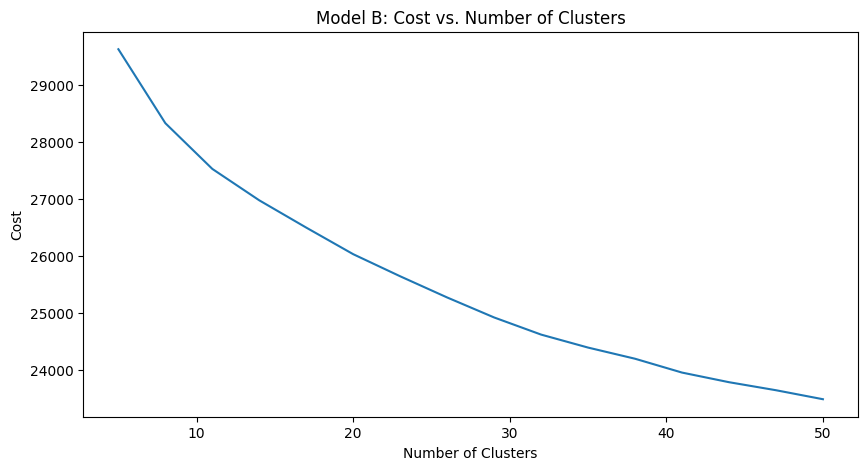

In [ ]:
# plot k clusters vs cost

plt.figure(figsize=(10, 5))
plt.plot(model_list_b, cost_list_b, label='Model cost')
plt.title('Model B: Cost vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()

In [ ]:
# selecting most optimal k by inspecting the elbow plot: k = 17 or 20

k=20

km_final_b = KModes(n_clusters=k, init='Cao', n_init=1, n_jobs=4, max_iter=15, random_state=random_state, verbose=0) # set random_state to global param
clusters_final_b = km_final_b.fit_predict(X_b)
print(f"Optimal centroids, k = {k}: \n {km_final_b.cluster_centroids_}")

Optimal centroids, k = 20: 
 [['gas_transport' 'Johnson LLC' 'M' 'Brooklyn' 'Print production planner'
  '$51 - $100' '51-100' '40-44 years' 'December']
 ['home' 'Johnson LLC' 'F' 'Denver' 'Quarry manager' '$0 - $10' '101-200'
  '25-29 years' 'March']
 ['misc_pos' 'Johnson LLC' 'F' 'Dallas' 'Administrator, education'
  '$26 - $50' '51-100' '35-39 years' 'May']
 ['personal_care' 'Johnson LLC' 'F' 'Houston' 'Radio producer' '$0 - $10'
  '51-100' '30-34 years' 'December']
 ['home' 'Johnson LLC' 'M' 'Lafayette' 'Immigration officer' '$0 - $10'
  '51-100' '45-49 years' 'May']
 ['home' 'Johnson LLC' 'F' 'Kenosha' 'Barista' '$51 - $100' '51-100'
  '20-24 years' 'February']
 ['personal_care' 'Johnson LLC' 'M' 'Brooklyn'
  'Government social research officer' '$26 - $50' '101-200'
  '20-24 years' 'September']
 ['gas_transport' 'Johnson LLC' 'F' 'Turlock' 'Prison officer'
  '$101 - $200' '51-100' '25-29 years' 'January']
 ['kids_pets' 'Johnson LLC' 'M' 'Groveland' 'Chief Strategy Officer'
  '$26

#### Model Variation C: Entertainment

In [ ]:
# create dict for clusters
cluster_dict_c = gen_cluster_dict(5, 50, 3)
print(cluster_dict_c)

{5: 5, 8: 8, 11: 11, 14: 14, 17: 17, 20: 20, 23: 23, 26: 26, 29: 29, 32: 32, 35: 35, 38: 38, 41: 41, 44: 44, 47: 47, 50: 50}


In [ ]:
# define and fit models based on cluster

best_cost_c = "init"
best_model_dict_c = {}
model_list_c = []
cost_list_c = []

for cluster, cluster_n in cluster_dict_c.items():
  km = KModes(n_clusters=cluster_n, init='Cao', n_init=1, n_jobs=4, max_iter=15, random_state=random_state, verbose=0) # set random_state to global param
  clusters = km.fit_predict(X_c) # as per documentation
  cost_list_c.append(km.cost_)
  model_list_c.append(cluster)
  if best_cost_c == "init":
    best_cost_c = km.cost_
    best_model_dict_c = {cluster:(km, km.cost_)}

  if km.cost_ < best_cost_c:
    best_cost_c = km.cost_
    best_model_dict_c = {cluster:(km, km.cost_)}

  print(f"Model fit for cluster {cluster} complete.")

Model fit for cluster 5 complete.
Model fit for cluster 8 complete.
Model fit for cluster 11 complete.
Model fit for cluster 14 complete.
Model fit for cluster 17 complete.
Model fit for cluster 20 complete.
Model fit for cluster 23 complete.
Model fit for cluster 26 complete.
Model fit for cluster 29 complete.
Model fit for cluster 32 complete.
Model fit for cluster 35 complete.
Model fit for cluster 38 complete.
Model fit for cluster 41 complete.
Model fit for cluster 44 complete.
Model fit for cluster 47 complete.
Model fit for cluster 50 complete.


In [ ]:
# view best model
best_model_dict_c

{50: (KModes(max_iter=15, n_clusters=50, n_init=1, n_jobs=4, random_state=42),
  1344922.0)}

In [ ]:
# Print the cluster centroids
for cluster, (model, cost) in best_model_dict_c.items():
    print(f"Best k = {cluster} \n")
    print(f"Cost = {cost} \n")
    print(f"Centroids: \n {model.cluster_centroids_}")

Best k = 50 

Cost = 1344922.0 

Centroids: 
 [['entertainment' 'Rodriguez LLC' 'M' 'Brooklyn'
  'Research scientist (life sciences)' '$0 - $10' '51-100' '25-29 years'
  'March']
 ['entertainment' 'Smith and Sons' 'F' 'Waterford' 'Data scientist'
  '$51 - $100' '51-100' '40-44 years' 'August']
 ['entertainment' 'Johnson Inc' 'F' 'Ridgefield'
  'Computer games developer' '$0 - $10' '101-200' '20-24 years' 'April']
 ['entertainment' 'Smith Ltd' 'F' 'Chicago' 'Chemical engineer'
  '$0 - $10' '51-100' '35-39 years' 'May']
 ['entertainment' 'Sanchez and Sons' 'M' 'San Antonio'
  'Therapist, nutritional' '$51 - $100' '101-200' '45-49 years' 'May']
 ['entertainment' 'Gonzalez Inc' 'M' 'Houston' 'Software engineer'
  '$51 - $100' '51-100' '20-24 years' 'April']
 ['entertainment' 'Williams Group' 'F' 'Farmington'
  'Nurse, mental health' '$26 - $50' '51-100' '20-24 years' 'March']
 ['entertainment' 'Williams PLC' 'M' 'Los Angeles' 'Call centre manager'
  '$26 - $50' '51-100' '40-44 years' 'May'

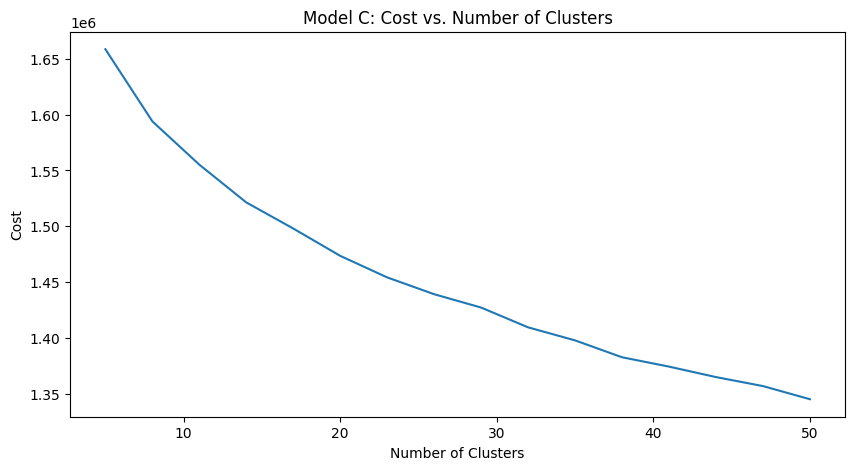

In [ ]:
# plot k clusters vs cost

plt.figure(figsize=(10, 5))
plt.plot(model_list_c, cost_list_c, label='Model cost')
plt.title('Model C: Cost vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()


In [ ]:
# selecting most optimal k by inspecting the elbow plot: k = 17 or 20

k=20

km_final_c = KModes(n_clusters=k, init='Cao', n_init=1, n_jobs=4, max_iter=15, random_state=random_state, verbose=0) # set random_state to global param
clusters_final_c = km_final_c.fit_predict(X_c)
print(f"Optimal centroids, k = {k}: \n {km_final_c.cluster_centroids_}")

Optimal centroids, k = 20: 
 [['entertainment' 'Rodriguez LLC' 'M' 'Brooklyn' 'Chief Strategy Officer'
  '$0 - $10' '51-100' '25-29 years' 'March']
 ['entertainment' 'Smith and Sons' 'F' 'Waterford' 'Data scientist'
  '$51 - $100' '51-100' '40-44 years' 'August']
 ['entertainment' 'Johnson Inc' 'F' 'Seattle' 'Computer games developer'
  '$0 - $10' '101-200' '20-24 years' 'April']
 ['entertainment' 'Smith Ltd' 'F' 'Chicago' 'Camera operator' '$0 - $10'
  '51-100' '35-39 years' 'May']
 ['entertainment' 'Sanchez and Sons' 'M' 'San Antonio'
  'Therapist, nutritional' '$51 - $100' '101-200' '45-49 years' 'May']
 ['entertainment' 'Gonzalez Inc' 'M' 'Houston' 'Software engineer'
  '$51 - $100' '51-100' '20-24 years' 'April']
 ['entertainment' 'Williams Group' 'F' 'Farmington'
  'Nurse, mental health' '$26 - $50' '51-100' '20-24 years' 'March']
 ['entertainment' 'Williams PLC' 'M' 'Los Angeles' 'Call centre manager'
  '$26 - $50' '51-100' '40-44 years' 'May']
 ['entertainment' 'Brown and Sons'

### 9. Assess Model Performance

In [ ]:
# there is no model performance assessment in unsupervised learning